In this script, I calculate 10 income deciles for different income data in the city of Madrid during a Normal Week, February 2022, and build assortativity matrices for the Renta bruta media por hogar variable in particular.
The variables for which income deciles are calculared are: ['Media de la renta por unidad de consumo', 'Mediana de la renta por unidad de consumo', 'Renta bruta media por hogar', 'Renta bruta media por persona', 'Renta neta media por hogar', 'Renta neta media por persona ']

Opening data...
Shape of the rent dataset:  (21, 8)
Shape of the mobility dataset:  (781697, 15)
Variable to calculate matrices on is set to:  Renta bruta media por hogar
Calculating 10 income deciles for the Renta bruta media por hogar data.


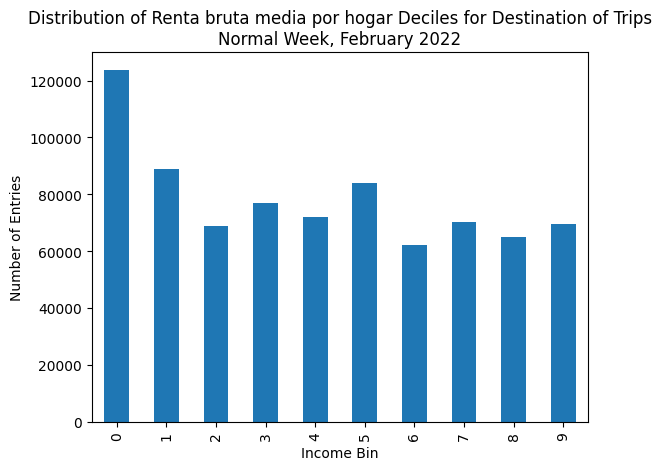

Encountered an error with pivot(): Index contains duplicate entries, cannot reshape
Switching to pivot_table() to handle duplicates.
Assortativity matrix created successfully.


<Figure size 640x480 with 0 Axes>

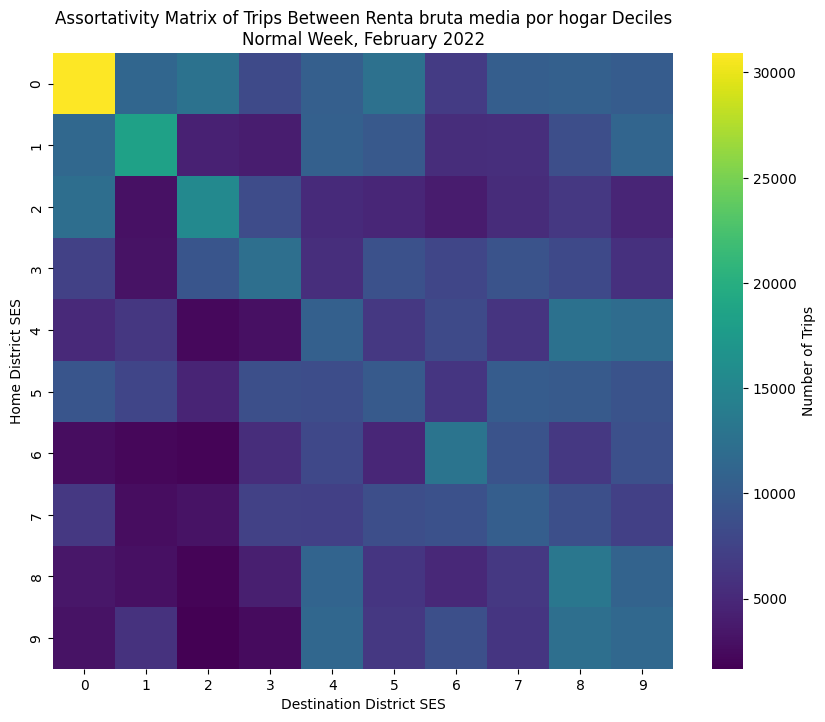

<Figure size 640x480 with 0 Axes>

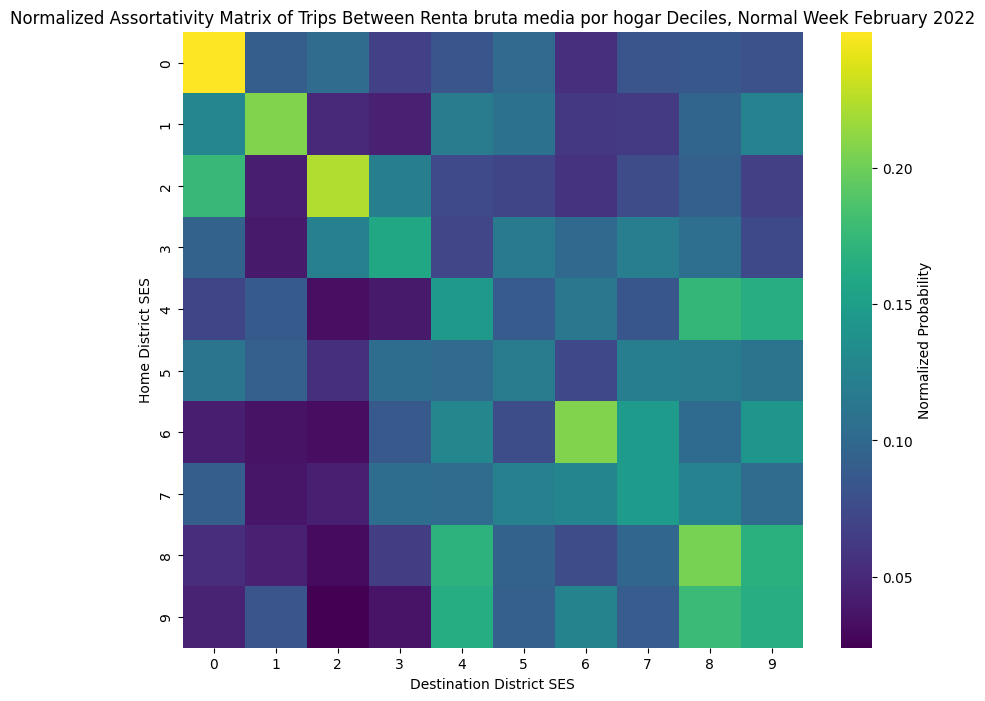

<Figure size 640x480 with 0 Axes>

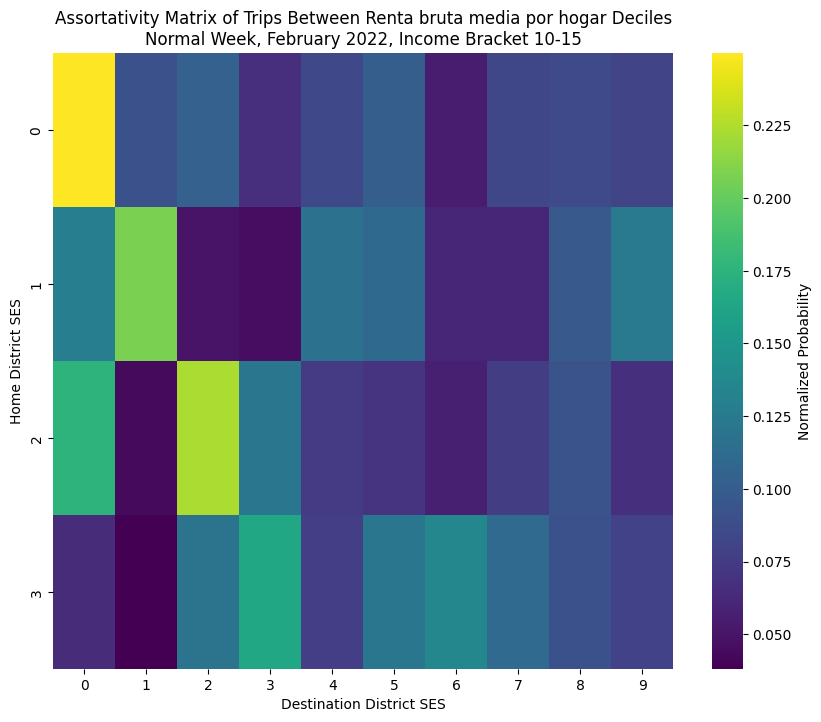

<Figure size 640x480 with 0 Axes>

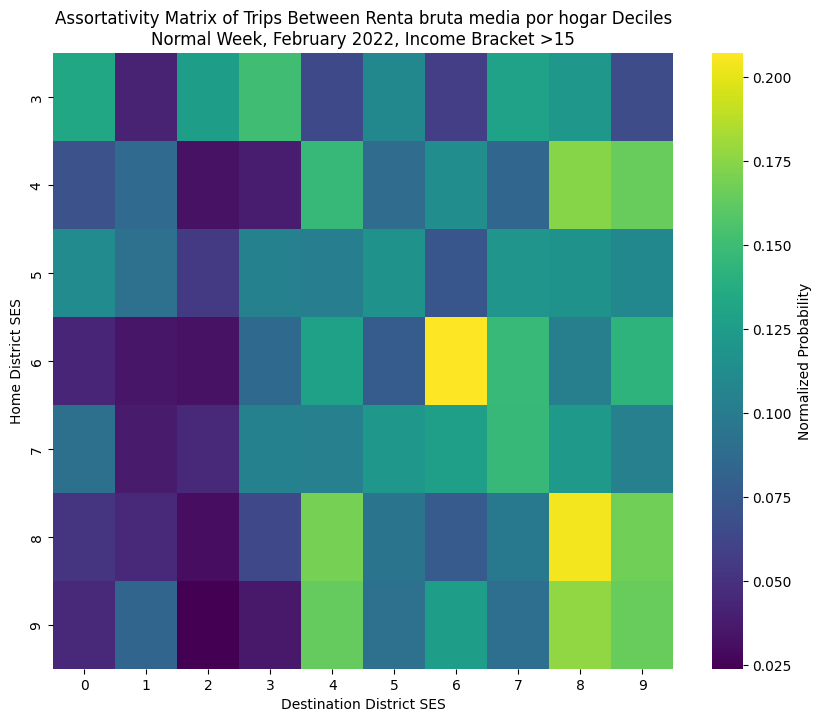

OSError: [Errno 22] Invalid argument: 'C:\\Users\\rqg886\\Desktop\\thesis_project\\segregation_indices\\figures\\week\\Assortativity Matrix of Trips Between Renta bruta media por hogar Deciles, Normal Week February 2022, Income Bracket >15.png'

<Figure size 640x480 with 0 Axes>

In [1]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import config as cfg
import pandas as pd
import geopandas as gpd

# FIXME: Make more efficient
# SET VARIABLES -----------------------------------------------------------------
var_of_interest = 'Renta bruta media por hogar' 
n_income_deciles = 10
if cfg.week:
    time_of_study = 'Normal Week, February 2022'
elif cfg.weekend:
    time_of_study = 'Normal Weekend, February 2022'
else:
    print('No time of study has been set')

print(f'In this script, I calculate {n_income_deciles} income deciles for different income data in the city of Madrid during a {time_of_study}, and build assortativity matrices for the {var_of_interest} variable in particular.')
print(f'The variables for which income deciles are calculared are: {cfg.INCOME_VARS_OF_INTEREST}')
print()
# OPEN DATA ----------------------------------------------------------------------
print('Opening data...')

rent_data = gpd.read_file(cfg.INCOME_DATA / 'geometries_and_income.geojson') # rent data to add to the viajes data to find income per district
rent_data = rent_data[['ID', 'geometry'] + cfg.INCOME_VARS_OF_INTEREST ] # here I select the variables of interest

if cfg.week:
    file_name = 'all_viajes_week_0222.csv'
elif cfg.weekend:
    file_name = 'all_viajes_weekend_0222.csv'
else:
    file_name = 'default_file.csv'  # Fallback option if neither is True

week = pd.read_csv(cfg.MOBILITY_DATA / f'VIAJES/{file_name}') # week of interest
week = week.loc[(week['actividad_origen'] == 'casa')] # filtering only trips from home!

print('Shape of the rent dataset: ', rent_data.shape)
print('Shape of the mobility dataset: ', week.shape)

# MERGE INCOME AND MOBILITY DATA ----------------------------------------------------------------------

viajes_with_income = pd.merge(
    week,
    rent_data,
    left_on='origen',  # The cleaned 'origen' from viajes DataFrame
    right_on='ID',  # The 'ID' from gdf
    how='left'  # Perform a left join to keep all rows from viajes
)

print('Variable to calculate matrices on is set to: ', var_of_interest)

# CALCULATE INCOME DECILES ----------------------------------------------------------------------

print(f'Calculating {n_income_deciles} income deciles for the {var_of_interest} data.')
rent_data['income_decile'] = pd.qcut(rent_data[var_of_interest], n_income_deciles, labels=False)

# Add deciles to dataframe
viajes_with_income = pd.merge(viajes_with_income, rent_data[['ID', 'income_decile']], 
                              left_on='origen', right_on='ID', how='left', suffixes=('', '_origin'))

viajes_with_income = pd.merge(viajes_with_income, rent_data[['ID', 'income_decile']], 
                              left_on='destino', right_on='ID', how='left', suffixes=('', '_dest'))
# Clean dataframe 
viajes_with_income.drop(columns=['residencia', 'estudio_origen_posible', 'estudio_origen_posible', 'ID', 'ID_origin', 'ID_dest'], inplace=True)

# PLOT INCOME DECILES -----------------------------------------------------------------------------------------------

bin_counts = viajes_with_income['income_decile'].value_counts().sort_index()
bin_counts.plot(kind='bar')

# 1. matplotlib
plt.xlabel('Income Bin')
plt.ylabel('Number of Entries')
plt.title(f'Distribution of {var_of_interest} Deciles for Destination of Trips\n{time_of_study}')
plt.show()

# 2. plotly
fig = px.bar(
    x=bin_counts.index,  # The 'Income Bin' values
    y=bin_counts.values,  # The 'Number of Entries' values
    labels={'x': 'Income Bin', 'y': 'Number of Entries'},
    title=f'Distribution of {var_of_interest} Deciles for Destination of Trips\n{time_of_study}'
)

fig.show()

if cfg.SAVE_FIGURES:
    fig.write_html(str(cfg.FIGURES_PATH / f'{var_of_interest}_deciles_distribution_destination.html'))
    plt.savefig(cfg.FIGURES_PATH / f'{var_of_interest}_deciles_distribution_destination.png', dpi=300, bbox_inches='tight')

# BUILD ASSORTATIVITY MATRICES ----------------------------------------------------------------------------------------

# Group by origin and destination deciles and count the trips
trip_counts_by_decile = viajes_with_income.groupby(['renta', 'income_decile', 'income_decile_dest']).size().reset_index(name='trip_count')
districts = rent_data['ID'].unique()

try:
    # Try using pivot() if there are no duplicate index/column combinations
    assortativity_matrix = trip_counts_by_decile.pivot(
        index='income_decile', 
        columns='income_decile_dest', 
        values='trip_count'
    ).fillna(0)

except ValueError as e:
    # If there's a ValueError (likely due to duplicate index/column pairs), fallback to pivot_table()
    print(f"Encountered an error with pivot(): {e}")
    print("Switching to pivot_table() to handle duplicates.")
    
    # Use pivot_table() with aggregation to handle duplicates
    assortativity_matrix = trip_counts_by_decile.pivot_table(
        index='income_decile', 
        columns='income_decile_dest', 
        values='trip_count', 
        aggfunc='sum',  # Aggregate duplicates by summing trip counts
        fill_value=0  # Fill missing values with 0
    )

# Continue with further processing or analysis of assortativity_matrix
print("Assortativity matrix created successfully.")

# Normalize 
assortativity_matrix_normalized = assortativity_matrix.div(assortativity_matrix.sum(axis=1), axis=0)

# PLOT AND SAVE ASSORTATIVITY MATRICES --------------------------------------------------------------------------------------

plt.figure(figsize=(10, 8))
sns.heatmap(assortativity_matrix, annot=False, cmap='viridis', cbar_kws={'label': 'Number of Trips'}, fmt=".2f")
plt.title(f'Assortativity Matrix of Trips Between {var_of_interest} Deciles\n{time_of_study}')
plt.xlabel('Destination District SES')
plt.ylabel('Home District SES')
plt.show()

if cfg.SAVE_FIGURES:
    plt.savefig(cfg.FIGURES_PATH / f'Assortativity Matrix of Trips Between {var_of_interest} Deciles, Normal Week February 2022.png', dpi=300, bbox_inches='tight')

plt.figure(figsize=(10, 8))
sns.heatmap(assortativity_matrix_normalized, annot=False, cmap='viridis', cbar_kws={'label': 'Normalized Probability'}, fmt=".2f")
plt.title(f'Normalized Assortativity Matrix of Trips Between {var_of_interest} Deciles, Normal Week February 2022')
plt.xlabel('Destination District SES')
plt.ylabel('Home District SES')   
plt.show()

if cfg.SAVE_FIGURES:
    plt.savefig(cfg.FIGURES_PATH / f'Normalized Assortativity Matrix of Trips Between {var_of_interest} Deciles, Normal Week February 2022.png', dpi=300, bbox_inches='tight')

# STRATIFY MOBILITY DATA BY RENT ----------------------------------------------------------------------------------

middle = trip_counts_by_decile[trip_counts_by_decile['renta']=='10-15']
high = trip_counts_by_decile[trip_counts_by_decile['renta']=='>15']

assortativity_matrix_middle = middle.pivot(index='income_decile', columns='income_decile_dest', values='trip_count').fillna(0)
assortativity_matrix_middle_normalized = assortativity_matrix_middle.div(assortativity_matrix_middle.sum(axis=1), axis=0)

assortativity_matrix_high = high.pivot(index='income_decile', columns='income_decile_dest', values='trip_count').fillna(0)
assortativity_matrix_high_normalized = assortativity_matrix_high.div(assortativity_matrix_high.sum(axis=1), axis=0)

# PLOT ASSORTATIVITY MATRICES STRATIFIED BY RENT ------------------------------------------------------------------

plt.figure(figsize=(10, 8))
sns.heatmap(assortativity_matrix_middle_normalized, annot=False, cmap='viridis', cbar_kws={'label': 'Normalized Probability'}, fmt=".2f")
plt.title(f'Assortativity Matrix of Trips Between {var_of_interest} Deciles\n{time_of_study}, Income Bracket 10-15')
plt.xlabel('Destination District SES')
plt.ylabel('Home District SES')
plt.show()

if cfg.SAVE_FIGURES:
    plt.savefig(cfg.FIGURES_PATH /f'Assortativity Matrix of Trips Between {var_of_interest} Deciles, Normal Week February 2022, Income Bracket 10-15.png', dpi=300, bbox_inches='tight')

plt.figure(figsize=(10, 8))
sns.heatmap(assortativity_matrix_high_normalized, annot=False, cmap='viridis', cbar_kws={'label': 'Normalized Probability'}, fmt=".2f")
plt.title(f'Assortativity Matrix of Trips Between {var_of_interest} Deciles\n{time_of_study}, Income Bracket >15')
plt.xlabel('Destination District SES')
plt.ylabel('Home District SES')
plt.show()

if cfg.SAVE_FIGURES:
    plt.savefig(cfg.FIGURES_PATH /f'Assortativity Matrix of Trips Between {var_of_interest} Deciles, Normal Week February 2022, Income Bracket Over 15.png', dpi=300, bbox_inches='tight')

In [4]:
fig = px.bar(
    x=bin_counts.index,  # The 'Income Bin' values
    y=bin_counts.values,  # The 'Number of Entries' values
    labels={'x': 'Income Bin', 'y': 'Number of Entries'},
    title=f'Distribution of {var_of_interest} Deciles for Destination of Trips, Normal Week February 2022'
)

fig.show()

In [5]:
if cfg.SAVE_FIGURES:
    # Save as an HTML file
    fig.write_html(str(cfg.FIGURES_PATH / f'{var_of_interest}_deciles_distribution_destination.html'))
    # Optionally save as a static image (requires 'kaleido' or 'orca' for Plotly)
    fig.write_image(str(cfg.FIGURES_PATH / f'{var_of_interest}_deciles_distribution_destination.png'), format='png', scale=3)
    print(f"Figure saved to {cfg.FIGURES_PATH / f'{var_of_interest}_deciles_distribution_destination.html'}")